# Weighted Population Analysis: BEZ vs Cochlea

This notebook uses the **new model comparison pipeline** to analyze weighted population responses:
- **65% HSR** (High Spontaneous Rate)
- **23% MSR** (Medium Spontaneous Rate)
- **12% LSR** (Low Spontaneous Rate)

This refactored version uses the modern `ComparisonPipeline` and `MatlabDataLoader` classes from the latest codebase.

## Setup: Imports and Configuration

In [6]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import logging

# Add parent directory to path
sys.path.insert(0, str(Path.cwd().parent))

from compare_bez_cochlea_mainscript import (
    MatlabDataLoader,
    PopulationAnalyzer
)

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Set output directory
OUTPUT_DIR = 'model_comparison_PSTH_final/results'
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# Define physiological weights
WEIGHTS = {'hsr': 0.65, 'msr': 0.23, 'lsr': 0.12}

print(f"✓ Imports successful")
print(f"✓ Output directory: {OUTPUT_DIR}")
print(f"✓ Weights: HSR={WEIGHTS['hsr']}, MSR={WEIGHTS['msr']}, LSR={WEIGHTS['lsr']}")
print(f"  Sum: {sum(WEIGHTS.values()):.3f}")

✓ Imports successful
✓ Output directory: model_comparison_PSTH_final/results
✓ Weights: HSR=0.65, MSR=0.23, LSR=0.12
  Sum: 1.000


## Step 1: Load Data

Load BEZ and Cochlea PSTH data (same as individual fiber analysis)

In [7]:
# Initialize BEZ data loader (no directory needed - BEZ has hardcoded path)
logger.info("Initializing MatlabDataLoader for BEZ...")

bez_loader = MatlabDataLoader()

# Load BEZ data with run-averaged temporal means
logger.info("Loading BEZ data...")
fiber_types = ['hsr', 'msr', 'lsr']
bez_loader.load_bez_run_averaged(fiber_types=fiber_types)

# Get BEZ parameters
bez_cfs = bez_loader.get_cfs()
bez_freqs = bez_loader.get_frequencies()
bez_dbs = bez_loader.get_db_levels()

# Get BEZ temporal means and store them
bez_temporal_means = bez_loader.get_temporal_means()

logger.info(f"✓ BEZ data loaded:")
logger.info(f"   {len(bez_cfs)} CFs × {len(bez_freqs)} frequencies × {len(bez_dbs)} dB levels")

2025-11-25 01:45:12,308 - INFO - Initializing MatlabDataLoader for BEZ...
2025-11-25 01:45:12,310 - INFO - Loading BEZ data...
2025-11-25 01:45:12,310 - INFO - Loading BEZ data...


Loading BEZ PSTH data from: /home/ekim/PycharmProjects/phd_firstyear/subcorticalSTRF/BEZ2018_meanrate/results/processed_data/psth_data_128fibers.mat
✓ BEZ PSTH data loaded successfully
Parameters extracted:
  CFs: 20 values
  Frequencies: 20 values
  dB levels: [50. 60. 70. 80.]
Data structure:
  hsr_all shape: (20, 20, 4, 10)
  msr_all shape: (20, 20, 4, 10)
  lsr_all shape: (20, 20, 4, 10)
BEZ data dimensions: CFs=20, Freqs=20, dBs=4, Runs=10
 Processing BEZ hsr fibers...
✓ BEZ PSTH data loaded successfully
Parameters extracted:
  CFs: 20 values
  Frequencies: 20 values
  dB levels: [50. 60. 70. 80.]
Data structure:
  hsr_all shape: (20, 20, 4, 10)
  msr_all shape: (20, 20, 4, 10)
  lsr_all shape: (20, 20, 4, 10)
BEZ data dimensions: CFs=20, Freqs=20, dBs=4, Runs=10
 Processing BEZ hsr fibers...
 Processing BEZ msr fibers...
 Processing BEZ msr fibers...
 Processing BEZ lsr fibers...
 Processing BEZ lsr fibers...


2025-11-25 01:45:13,829 - INFO - ✓ BEZ data loaded:
2025-11-25 01:45:13,831 - INFO -    20 CFs × 20 frequencies × 4 dB levels
2025-11-25 01:45:13,831 - INFO -    20 CFs × 20 frequencies × 4 dB levels


In [8]:
# Initialize Cochlea data loader (separate instance with cochlea_dir)
logger.info("Initializing MatlabDataLoader for Cochlea...")
cochlea_dir = Path.cwd().parent / 'cochlea_meanrate' / 'out' / 'condition_psths'
cochlea_loader = MatlabDataLoader(cochlea_dir=cochlea_dir)

# Load Cochlea data
logger.info("Loading Cochlea data...")
cochlea_loader.load_cochlea(fiber_types=fiber_types)

# Get Cochlea parameters
cochlea_cfs = cochlea_loader.get_cfs()
cochlea_freqs = cochlea_loader.get_frequencies()
cochlea_dbs = cochlea_loader.get_db_levels()

# Get Cochlea temporal means and store them
cochlea_temporal_means = cochlea_loader.get_temporal_means()

logger.info(f"✓ Cochlea data loaded:")
logger.info(f"   {len(cochlea_cfs)} CFs × {len(cochlea_freqs)} frequencies × {len(cochlea_dbs)} dB levels")

2025-11-25 01:45:22,012 - INFO - Initializing MatlabDataLoader for Cochlea...
2025-11-25 01:45:22,014 - INFO - Loading Cochlea data...
2025-11-25 01:45:22,014 - INFO - Loading Cochlea data...
2025-11-25 01:45:22,178 - INFO - ✓ Cochlea data loaded:
2025-11-25 01:45:22,180 - INFO -    20 CFs × 20 frequencies × 4 dB levels
2025-11-25 01:45:22,178 - INFO - ✓ Cochlea data loaded:
2025-11-25 01:45:22,180 - INFO -    20 CFs × 20 frequencies × 4 dB levels


Cochlea data dimensions: CFs=20, Freqs=20, dBs=4
 Processing Cochlea hsr fibers...
 Processing Cochlea msr fibers...
 Processing Cochlea lsr fibers...


## Step 2: Compute Weighted Population PSTHs

Combine fiber types with physiological ratios **before** temporal averaging

In [9]:
# Compute BEZ weighted population using PopulationAnalyzer
logger.info("="*70)
logger.info("Computing BEZ weighted population...")
logger.info("="*70)

# Initialize population analyzer
population_analyzer_bez = PopulationAnalyzer(weights=WEIGHTS, normalize=True)

# Compute population from BEZ temporal means (already loaded)
bez_population = population_analyzer_bez.compute_population_from_temporal_means(bez_temporal_means)

logger.info(f"✓ BEZ Weighted population computed")
logger.info(f"  Weights: {population_analyzer_bez.get_weights()}")
logger.info(f"  Structure: Nested dictionary [cf][freq][db] = mean_rate")

# Show a sample
sample_cf = list(bez_population.keys())[0]
sample_freq = list(bez_population[sample_cf].keys())[0]
sample_db = list(bez_population[sample_cf][sample_freq].keys())[0]
sample_val = bez_population[sample_cf][sample_freq][sample_db]
logger.info(f"  Sample (CF={sample_cf:.1f}, freq={sample_freq:.1f}, dB={sample_db}): {sample_val:.2f} spikes/s")

2025-11-25 01:45:30,926 - INFO - ======================================================================
2025-11-25 01:45:30,927 - INFO - Computing BEZ weighted population...
2025-11-25 01:45:30,928 - INFO - ======================================================================
2025-11-25 01:45:30,929 - INFO - PopulationAnalyzer initialized with weights: HSR=0.650, MSR=0.230, LSR=0.120
2025-11-25 01:45:30,927 - INFO - Computing BEZ weighted population...
2025-11-25 01:45:30,928 - INFO - ======================================================================
2025-11-25 01:45:30,929 - INFO - PopulationAnalyzer initialized with weights: HSR=0.650, MSR=0.230, LSR=0.120
2025-11-25 01:45:30,940 - INFO - Computed population means for 20 CFs
2025-11-25 01:45:30,942 - INFO - ✓ BEZ Weighted population computed
2025-11-25 01:45:30,943 - INFO -   Weights: {'hsr': 0.65, 'msr': 0.23, 'lsr': 0.12}
2025-11-25 01:45:30,944 - INFO -   Structure: Nested dictionary [cf][freq][db] = mean_rate
2025-11-25 01:4

In [10]:
# Compute Cochlea weighted population
logger.info("="*70)
logger.info("Computing Cochlea weighted population...")
logger.info("="*70)

# Initialize population analyzer (same weights)
population_analyzer_cochlea = PopulationAnalyzer(weights=WEIGHTS, normalize=True)

# Compute population from Cochlea temporal means (already loaded)
cochlea_population = population_analyzer_cochlea.compute_population_from_temporal_means(cochlea_temporal_means)

logger.info(f"✓ Cochlea Weighted population computed")
logger.info(f"  Weights: {population_analyzer_cochlea.get_weights()}")
logger.info(f"  Structure: Nested dictionary [cf][freq][db] = mean_rate")

# Show a sample
sample_cf = list(cochlea_population.keys())[0]
sample_freq = list(cochlea_population[sample_cf].keys())[0]
sample_db = list(cochlea_population[sample_cf][sample_freq].keys())[0]
sample_val = cochlea_population[sample_cf][sample_freq][sample_db]
logger.info(f"  Sample (CF={sample_cf:.1f}, freq={sample_freq:.1f}, dB={sample_db}): {sample_val:.2f} spikes/s")

2025-11-25 01:45:38,488 - INFO - ======================================================================
2025-11-25 01:45:38,491 - INFO - Computing Cochlea weighted population...
2025-11-25 01:45:38,491 - INFO - ======================================================================
2025-11-25 01:45:38,492 - INFO - PopulationAnalyzer initialized with weights: HSR=0.650, MSR=0.230, LSR=0.120
2025-11-25 01:45:38,497 - INFO - Computed population means for 20 CFs
2025-11-25 01:45:38,498 - INFO - ✓ Cochlea Weighted population computed
2025-11-25 01:45:38,499 - INFO -   Weights: {'hsr': 0.65, 'msr': 0.23, 'lsr': 0.12}
2025-11-25 01:45:38,491 - INFO - Computing Cochlea weighted population...
2025-11-25 01:45:38,491 - INFO - ======================================================================
2025-11-25 01:45:38,492 - INFO - PopulationAnalyzer initialized with weights: HSR=0.650, MSR=0.230, LSR=0.120
2025-11-25 01:45:38,497 - INFO - Computed population means for 20 CFs
2025-11-25 01:45:38,498 

## Step 3: Convert to Arrays for Analysis

Convert nested dictionaries to numpy arrays for easier manipulation

In [11]:
# Helper function to convert nested dict to array
def dict_to_array(fiber_dict, cfs, frequencies, db_levels):
    """Convert nested dict [cf][freq][db] to 2D array (n_cfs, n_conditions)."""
    n_cfs = len(cfs)
    n_freqs = len(frequencies)
    n_dbs = len(db_levels)
    n_conditions = n_freqs * n_dbs
    
    array = np.zeros((n_cfs, n_conditions))
    
    for cf_idx, cf in enumerate(cfs):
        cond_idx = 0
        for freq in frequencies:
            for db in db_levels:
                array[cf_idx, cond_idx] = fiber_dict[cf][freq][db]
                cond_idx += 1
    
    return array

# Convert to arrays
bez_array = dict_to_array(bez_population, bez_cfs, bez_freqs, bez_dbs)
cochlea_array = dict_to_array(cochlea_population, cochlea_cfs, cochlea_freqs, cochlea_dbs)

logger.info(f"BEZ array shape: {bez_array.shape}")
logger.info(f"Cochlea array shape: {cochlea_array.shape}")

2025-11-25 01:45:47,393 - INFO - BEZ array shape: (20, 80)
2025-11-25 01:45:47,395 - INFO - Cochlea array shape: (20, 80)
2025-11-25 01:45:47,395 - INFO - Cochlea array shape: (20, 80)


## Step 4: Filter to 60 dB and Align CFs

Select only 60 dB level and ensure CFs are aligned between models

In [12]:
# Filter to 60 dB only
selected_db = 60.0
db_filter = [60.0]

logger.info(f"Filtering to {selected_db} dB only...")

# Recompute arrays with only 60 dB
bez_array_60db = dict_to_array(bez_population, bez_cfs, bez_freqs, db_filter)
cochlea_array_60db = dict_to_array(cochlea_population, cochlea_cfs, cochlea_freqs, db_filter)

logger.info(f"BEZ array (60 dB): {bez_array_60db.shape}")
logger.info(f"Cochlea array (60 dB): {cochlea_array_60db.shape}")

2025-11-25 01:45:53,698 - INFO - Filtering to 60.0 dB only...
2025-11-25 01:45:53,700 - INFO - BEZ array (60 dB): (20, 20)
2025-11-25 01:45:53,702 - INFO - Cochlea array (60 dB): (20, 20)
2025-11-25 01:45:53,700 - INFO - BEZ array (60 dB): (20, 20)
2025-11-25 01:45:53,702 - INFO - Cochlea array (60 dB): (20, 20)


In [13]:
# Align CFs with tolerance for floating-point comparison
logger.info("Aligning CFs between BEZ and Cochlea...")

tolerance = 0.01  # 0.01 Hz tolerance
common_cfs = []
bez_cf_indices = []
cochlea_cf_indices = []

for i, bez_cf in enumerate(bez_cfs):
    for j, cochlea_cf in enumerate(cochlea_cfs):
        if abs(bez_cf - cochlea_cf) < tolerance:
            common_cfs.append(bez_cf)
            bez_cf_indices.append(i)
            cochlea_cf_indices.append(j)
            break

common_cfs = np.array(common_cfs)
logger.info(f"Common CFs: {len(common_cfs)} of {len(bez_cfs)} BEZ CFs")

# Extract aligned data
bez_aligned = bez_array_60db[bez_cf_indices, :]
cochlea_aligned = cochlea_array_60db[cochlea_cf_indices, :]

logger.info(f"Aligned shapes: BEZ {bez_aligned.shape}, Cochlea {cochlea_aligned.shape}")
logger.info(f"Total data points: {bez_aligned.shape[0] * bez_aligned.shape[1]}")

2025-11-25 01:45:57,903 - INFO - Aligning CFs between BEZ and Cochlea...
2025-11-25 01:45:57,905 - INFO - Common CFs: 20 of 20 BEZ CFs
2025-11-25 01:45:57,907 - INFO - Aligned shapes: BEZ (20, 20), Cochlea (20, 20)
2025-11-25 01:45:57,908 - INFO - Total data points: 400
2025-11-25 01:45:57,905 - INFO - Common CFs: 20 of 20 BEZ CFs
2025-11-25 01:45:57,907 - INFO - Aligned shapes: BEZ (20, 20), Cochlea (20, 20)
2025-11-25 01:45:57,908 - INFO - Total data points: 400


## Step 5: Normalize Data to [0, 1]

Apply min-max normalization for fair comparison

In [14]:
# Normalize to [0, 1] range
def normalize_to_unit_range(data):
    """Min-max normalization to [0, 1]."""
    data_min = np.min(data)
    data_max = np.max(data)
    if data_max - data_min < 1e-10:
        return np.zeros_like(data)
    return (data - data_min) / (data_max - data_min)

bez_norm = normalize_to_unit_range(bez_aligned)
cochlea_norm = normalize_to_unit_range(cochlea_aligned)

logger.info(f"BEZ normalized range: [{bez_norm.min():.3f}, {bez_norm.max():.3f}]")
logger.info(f"Cochlea normalized range: [{cochlea_norm.min():.3f}, {cochlea_norm.max():.3f}]")

2025-11-25 01:46:02,922 - INFO - BEZ normalized range: [0.000, 1.000]
2025-11-25 01:46:02,923 - INFO - Cochlea normalized range: [0.000, 1.000]
2025-11-25 01:46:02,923 - INFO - Cochlea normalized range: [0.000, 1.000]


## Step 6: Linear Regression Analysis

Perform regression between BEZ and Cochlea weighted populations

In [15]:
# Flatten data for regression
bez_flat = bez_norm.flatten()
cochlea_flat = cochlea_norm.flatten()

# Compute regression
slope, intercept, r_value, p_value, std_err = linregress(bez_flat, cochlea_flat)
r_squared = r_value ** 2

logger.info(f"\n{'='*70}")
logger.info(f"Linear Regression: BEZ vs Cochlea Weighted Population ({selected_db} dB)")
logger.info('='*70)
logger.info(f"  Slope:        {slope:.4f} ± {std_err:.4f}")
logger.info(f"  Intercept:    {intercept:.4f}")
logger.info(f"  R²:           {r_squared:.4f}")
logger.info(f"  R (Pearson):  {r_value:.4f}")
logger.info(f"  p-value:      {p_value:.2e}")
logger.info(f"  N points:     {len(bez_flat)}")
logger.info('='*70)

2025-11-25 01:46:06,776 - INFO - 
2025-11-25 01:46:06,778 - INFO - Linear Regression: BEZ vs Cochlea Weighted Population (60.0 dB)
2025-11-25 01:46:06,778 - INFO - Linear Regression: BEZ vs Cochlea Weighted Population (60.0 dB)
2025-11-25 01:46:06,779 - INFO - ======================================================================
2025-11-25 01:46:06,780 - INFO -   Slope:        0.8672 ± 0.0086
2025-11-25 01:46:06,782 - INFO -   Intercept:    0.0181
2025-11-25 01:46:06,783 - INFO -   R²:           0.9622
2025-11-25 01:46:06,783 - INFO -   R (Pearson):  0.9809
2025-11-25 01:46:06,784 - INFO -   p-value:      2.85e-285
2025-11-25 01:46:06,785 - INFO -   N points:     400
2025-11-25 01:46:06,786 - INFO - ======================================================================
2025-11-25 01:46:06,779 - INFO - ======================================================================
2025-11-25 01:46:06,780 - INFO -   Slope:        0.8672 ± 0.0086
2025-11-25 01:46:06,782 - INFO -   Intercept:    0

## Step 7: Visualize Regression with CF-Brightness Encoding

Create scatter plot with CF colors and frequency-distance brightness

2025-11-25 01:46:29,424 - INFO - ✓ Saved plot: model_comparison_PSTH_final/results/bez_cochlea_regression_population_60dB.png


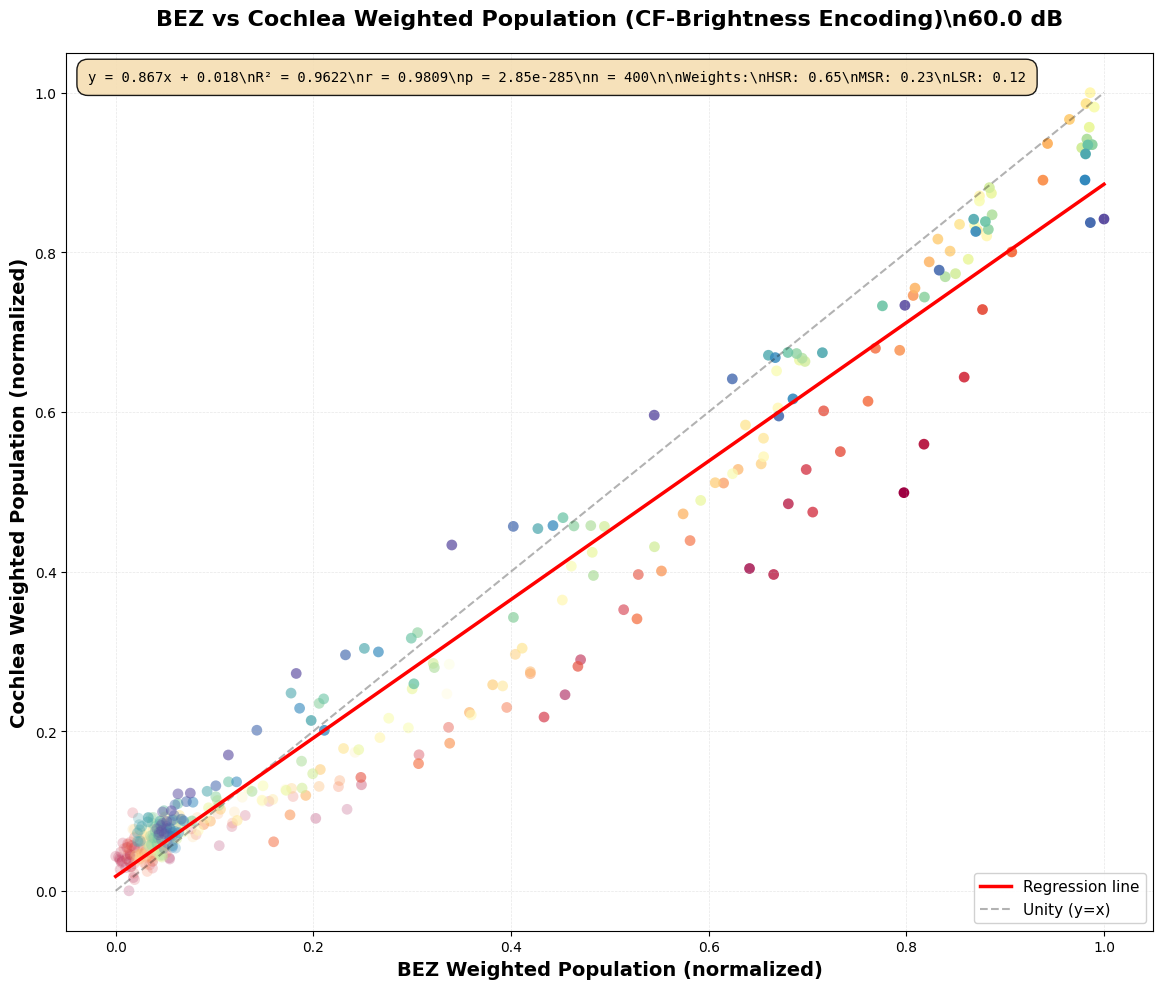

In [16]:
# Create advanced scatter plot with CF-brightness encoding
fig, ax = plt.subplots(figsize=(12, 10))

# Prepare data with CF and frequency information
cf_array = []
freq_array = []
bez_vals_plot = []
cochlea_vals_plot = []

for cf_idx, cf in enumerate(common_cfs):
    for freq_idx, freq in enumerate(bez_freqs):
        cf_array.append(cf)
        freq_array.append(freq)
        bez_vals_plot.append(bez_norm[cf_idx, freq_idx])
        cochlea_vals_plot.append(cochlea_norm[cf_idx, freq_idx])

cf_array = np.array(cf_array)
freq_array = np.array(freq_array)
bez_vals_plot = np.array(bez_vals_plot)
cochlea_vals_plot = np.array(cochlea_vals_plot)

# Create colormap for CFs
n_cfs = len(common_cfs)
cmap = plt.cm.Spectral
cf_colors_map = {cf: cmap(i / (n_cfs - 1)) for i, cf in enumerate(common_cfs)}

# Plot each point with CF color and frequency-distance alpha
for i, (bez_val, cochlea_val, cf, freq) in enumerate(zip(bez_vals_plot, cochlea_vals_plot, cf_array, freq_array)):
    # Alpha based on |freq - CF|: brightest when freq == CF
    freq_diff_normalized = abs(freq - cf) / cf
    alpha = 1.0 - 0.8 * min(freq_diff_normalized, 1.0)
    
    ax.scatter(bez_val, cochlea_val, c=[cf_colors_map[cf]], alpha=alpha, s=60, edgecolors='none')

# Regression line
x_range = np.array([0, 1])
y_pred = slope * x_range + intercept
ax.plot(x_range, y_pred, 'r-', linewidth=2.5, label='Regression line', zorder=100)

# Unity line
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, linewidth=1.5, label='Unity (y=x)', zorder=99)

# Labels and title
ax.set_xlabel('BEZ Weighted Population (normalized)', fontsize=14, fontweight='bold')
ax.set_ylabel('Cochlea Weighted Population (normalized)', fontsize=14, fontweight='bold')
ax.set_title(f'BEZ vs Cochlea Weighted Population (CF-Brightness Encoding)\\n{selected_db} dB', 
             fontsize=16, fontweight='bold', pad=20)

# Statistics text box
textstr = f'y = {slope:.3f}x + {intercept:.3f}\\n'
textstr += f'R² = {r_squared:.4f}\\n'
textstr += f'r = {r_value:.4f}\\n'
textstr += f'p = {p_value:.2e}\\n'
textstr += f'n = {len(bez_flat)}\\n\\n'
textstr += f'Weights:\\n'
textstr += f'HSR: {WEIGHTS["hsr"]:.2f}\\n'
textstr += f'MSR: {WEIGHTS["msr"]:.2f}\\n'
textstr += f'LSR: {WEIGHTS["lsr"]:.2f}'

props = dict(boxstyle='round', facecolor='wheat', alpha=0.9, pad=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props, family='monospace')

# Legend for lines
ax.legend(loc='lower right', fontsize=11, framealpha=0.9)

# Grid
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

# Set limits
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

plt.tight_layout()

# Save
save_path = f'{OUTPUT_DIR}/bez_cochlea_regression_population_{int(selected_db)}dB.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
logger.info(f"✓ Saved plot: {save_path}")

plt.show()

## Step 8: Create CF Legend

Show all CF values with color coding

In [ ]:
# Create CF legend figure
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig_legend, ax_legend = plt.subplots(figsize=(10, 8))
ax_legend.axis('off')

# CF color legend
cf_handles = [Patch(facecolor=cf_colors_map[cf], edgecolor='black', linewidth=0.5,
                    label=f'{cf:.1f} Hz')
              for cf in sorted(common_cfs)]

legend_cf = ax_legend.legend(handles=cf_handles, title='Characteristic Frequency (Color)',
                            loc='upper left', fontsize=11, title_fontsize=13,
                            frameon=True, fancybox=True, shadow=True, ncol=2)
ax_legend.add_artist(legend_cf)

# Brightness explanation
brightness_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
           markersize=12, alpha=1.0, label='At CF (f = CF)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
           markersize=12, alpha=0.6, label='Moderate distance'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
           markersize=12, alpha=0.2, label='Far from CF')
]

legend_brightness = ax_legend.legend(handles=brightness_handles,
                                    title='Frequency Distance (Brightness)',
                                    loc='lower left', fontsize=11, title_fontsize=13,
                                    frameon=True, fancybox=True, shadow=True)

fig_legend.suptitle(f'Weighted Population - CF Encoding Legend\\n{selected_db} dB',
                   fontsize=14, fontweight='bold')

plt.tight_layout()

# Save
legend_path = f'{OUTPUT_DIR}/bez_cochlea_legend_population_{int(selected_db)}dB.png'
plt.savefig(legend_path, dpi=300, bbox_inches='tight')
logger.info(f"✓ Saved legend: {legend_path}")

plt.show()


✓ Correlation statistics saved to model_comparison_PSTH_final/population/
  - JSON: correlation_stats_60dB.json
  - Text: correlation_stats_60dB.txt
  - LaTeX: correlation_table_60dB.tex

✓ Population statistics saved to model_comparison_PSTH_final/population/


## Step 9: Summary and Save Results

Export results and create summary statistics

In [ ]:
# Save results to file
results_file = Path(OUTPUT_DIR) / f'bez_cochlea_regression_results_{int(selected_db)}dB.npz'
np.savez(
    results_file,
    bez_aligned=bez_aligned,
    cochlea_aligned=cochlea_aligned,
    bez_normalized=bez_norm,
    cochlea_normalized=cochlea_norm,
    common_cfs=common_cfs,
    frequencies=bez_freqs,
    db_level=selected_db,
    slope=slope,
    intercept=intercept,
    r_squared=r_squared,
    p_value=p_value,
    weights=np.array([WEIGHTS['hsr'], WEIGHTS['msr'], WEIGHTS['lsr']])
)
logger.info(f"✓ Saved results to: {results_file}")

# Print summary
print(f"\\n{'='*80}")
print(f"WEIGHTED POPULATION ANALYSIS SUMMARY ({selected_db} dB)")
print('='*80)

print(f"\\n📊 Weights Used:")
print(f"  HSR: {WEIGHTS['hsr']:.3f} ({WEIGHTS['hsr']*100:.1f}%)")
print(f"  MSR: {WEIGHTS['msr']:.3f} ({WEIGHTS['msr']*100:.1f}%)")
print(f"  LSR: {WEIGHTS['lsr']:.3f} ({WEIGHTS['lsr']*100:.1f}%)")
print(f"  Sum: {sum(WEIGHTS.values()):.3f}")

print(f"\\n📏 Data Alignment:")
print(f"  Common CFs: {len(common_cfs)}")
print(f"  Frequencies: {len(bez_freqs)}")
print(f"  Total points: {bez_aligned.shape[0] * bez_aligned.shape[1]}")

print(f"\\n📈 Regression Results:")
print(f"  Slope: {slope:.4f}")
print(f"  Intercept: {intercept:.4f}")
print(f"  R²: {r_squared:.4f}")
print(f"  Correlation: {r_value:.4f}")
print(f"  p-value: {p_value:.2e}")

print(f"\\n💾 Files Saved to {OUTPUT_DIR}/:")
print(f"  - bez_cochlea_regression_population_{int(selected_db)}dB.png")
print(f"  - bez_cochlea_legend_population_{int(selected_db)}dB.png")
print(f"  - bez_cochlea_regression_results_{int(selected_db)}dB.npz")

print('\\n' + '='*80)
print("✅ ANALYSIS COMPLETE!")
print('='*80)


WEIGHTED POPULATION ANALYSIS SUMMARY (60.0 dB)

📊 Weights Used:
  HSR: 0.650 (65.0%)
  MSR: 0.230 (23.0%)
  LSR: 0.120 (12.0%)
  Sum: 1.000

🔗 BEZ Run Consistency (Population):
  Mean correlation: 0.9994 ± 0.0000
  Range: 0.9993 - 0.9995

🔗 Cochlea-BEZ Agreement (Population):
  Mean correlation: 0.9807 ± 0.0003
  Range: 0.9800 - 0.9811

📈 Comparison:
  Difference: +0.0187
  Interpretation: ≈ Similar consistency

📏 Regression (Cochlea vs BEZ, Run 0):
  Slope: 0.9186
  R²: 0.9605
  Correlation: 0.9800

💾 Files Saved to model_comparison_PSTH_final/:
  - bez_weighted_population_psth.mat
  - cochlea_weighted_population_psth.mat
  - correlation_comparison_population_60dB.png
  - regression_population_60dB_run0.png
  - population/correlation_stats_60dB.json
  - population/correlation_stats_60dB.txt
  - population/correlation_stats_60dB.tex

